# Train Model 

This trains your model to use for image classification. Some of the steps are optional (and these are marked). If you resize the images before training, make sure to also resize them in evaluate.py so you are training on the same types of images as you are evaluating.

Much of this code is borrowed from FastAI's Lesson #1 in their deep learning MOOC

## SETUP Files

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
from glob import glob
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [335]:
## Enter the relevant paths. You need to keep "valid" and "train" and "test" as they are for the FastAI library to work

# Change these
FASTAI_PATH = '/home/paperspace/fastai/' 
IMG_PATH = '/home/paperspace/kitchen_clean/imgs/180322'
classes = ['clean', 'dirty', 'people']
model_path = os.path.join(IMG_PATH, 'saved_model')

#leave these
train_path = os.path.join(IMG_PATH,'train')
val_path = os.path.join(IMG_PATH,'valid')
test_path = os.path.join(IMG_PATH, 'test')



In [336]:
sz = 224 #size of images for the ResNet34 model. Don't change if using pretrained weights. 
batch_size = 64 #good for GPUs. Use smaller for CPUs
arch=resnet34 #Can change to another model if you so choose...

In [66]:
#Sets up directory structure

def setup_dirs(img_path, classes):
    
    if not os.path.isdir(img_path):
        os.mkdir(img_path)
    
    subdirs = ['train', 'valid', 'test', 'saved_model']
    for dirs in subdirs:
        new_path = os.path.join(img_path,dirs)
        if not os.path.isdir(new_path):
            os.mkdir(new_path)
        
        if dirs in ['train', 'valid']:
            for cls in classes:
                cls_dir = os.path.join(new_path,cls)
                if not os.path.isdir(cls_dir):
                    os.mkdir(cls_dir)
                    
    return

In [67]:
# Only need to run once if directory not setup
setup_dirs(IMG_PATH, classes)

In [337]:
### OPTIONAL Step 1: RESIZE IMAGES. The resnet model will resize and crop images to a 224x224 pixels. 
#If you want to squish the images instead of cropping them (to get the full scene), use this.
# It will create a new directory with the resized images. 

new_path = IMG_PATH+'-RESIZE_L'
setup_dirs(new_path, classes)

subdirs = ['train', 'valid'] 

for subdir in subdirs:
    
    for cls in classes:
        pth = os.path.join(IMG_PATH,subdir,cls)
        files = os.listdir(pth)
        
        for f in files:
            im = Image.open(os.path.join(IMG_PATH,subdir,cls,f))
            new_img = im.resize((sz,sz), resample = PIL.Image.LANCZOS)
            new_img.save(os.path.join(new_path, subdir,cls,f))

# Note: Changes the image paths to the location of the new resized images
IMG_PATH = new_path
train_path = os.path.join(IMG_PATH,'train')
val_path = os.path.join(IMG_PATH,'valid')
test_path = os.path.join(IMG_PATH, 'test')
model_path = os.path.join(IMG_PATH, 'saved_model')

In [91]:
### OPTIONAL step 2: UPSAMPLE RARER CLASSES
# If there is an imbalance of images in the classes, it may screw results. This duplicates images at random to even class distribution.

def upsample(train_path, classes):
    
    cls_len = [len(os.listdir(os.path.join(train_path, cls))) for cls in classes]
    
    cls_ratio = [float(cls_l) / float(max(cls_len)) for cls_l in cls_len]
    
    print(cls_len)
    
    for i,cls in enumerate(classes):
        
        class_dir = os.path.join(train_path, cls)
        additional_imgs = int(cls_len[i]/cls_ratio[i] - cls_len[i])
        
        files = os.listdir(class_dir)
        files = np.random.choice(files, additional_imgs)
        
        dup_files = files[:additional_imgs]
        
        num_files = 0
        for dup_file in dup_files:
            shutil.copy(os.path.join(class_dir,dup_file), os.path.join(class_dir,'DUP-'+dup_file))
            num_files+=1
        print('{} files copied in class {}'.format(num_files,cls))
    
    return

In [92]:
upsample(train_path, classes)

[48, 86, 198]
150 files copied in class clean
112 files copied in class dirty
0 files copied in class people


In [33]:
# Creates validation images
# Takes r% of images and puts them in val_path. Only run once. 

def setup_validation_sample(train_path, val_path, classes, r = 0.2):
    
    for cls in classes:
        do_move = True
        
        val_cls_dir = os.path.join(val_path, cls)
        train_cls_dir = os.path.join(train_path, cls)
        
        
        if len(os.listdir(val_cls_dir)) > 0:
            print('already validation files in dir: {}'.format(cls)) 
            do_move = False
        
        if len(os.listdir(train_cls_dir)) == 0:
            print('no training images for: {}'.format(cls))
            do_move = False
            
        if do_move:
            files = os.listdir(train_cls_dir)
            np.random.shuffle(files)
            
            num_moved = 0 
            
            for f in files[:int(len(files) * r)]:
                shutil.move(os.path.join(train_cls_dir,f), val_cls_dir)
                num_moved+=1
            
            print('{} files from class {} moved'.format(num_moved,cls)) 
        
    return

In [34]:
setup_validation_sample(train_path, val_path, classes, r = 0.2)

/home/paperspace/kitchen_clean/imgs/180322/valid/clean
/home/paperspace/kitchen_clean/imgs/180322/train/clean
already validation files in dir: clean
/home/paperspace/kitchen_clean/imgs/180322/valid/dirty
/home/paperspace/kitchen_clean/imgs/180322/train/dirty
already validation files in dir: dirty
/home/paperspace/kitchen_clean/imgs/180322/valid/people
/home/paperspace/kitchen_clean/imgs/180322/train/people
already validation files in dir: people


## Train model

In [272]:
#symlink
import sys
sys.path.append(FASTAI_PATH)

In [273]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [274]:
import torchvision.models as models
import torch.nn as nn
import torch

In [275]:
torch.cuda.is_available()

True

In [276]:
torch.backends.cudnn.enabled

True

In [338]:
#image augmentation assuming side_on orientation. Can also try transforms_top_down for overhead images. 
# Creates additional images for training. 
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [339]:
data = ImageClassifierData.from_paths(IMG_PATH, tfms=tfms, bs = batch_size)

In [351]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [353]:
#First training. You'll want to play around with learning rates. See FastAI Lesson 1 for descsription of how they do learning rates.
# This only trains the final layer
learn.fit(.01, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.565075   0.581842   0.835069  
    1      0.558721   0.591885   0.835069                



[0.591885, 0.8350694477558136]

In [ ]:
learn.fit(.001, 3, cycle_len=1)

In [357]:
# Optional: Unfreeze all layers to adjust them
learn.unfreeze()
learn.fit(.0001, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.538933   0.44007    0.842882  
    1      0.535609   0.419581   0.886285                
    2      0.534144   0.403201   0.886285                



[0.40320092, 0.8862847089767456]

In [365]:
## Save file. This is what you'll need to put in the model folder to run evaluate.py
torch.save(learn.model.cpu(), os.path.join(model_path,'180313-resize-cpu'))

## OPTIONAL: Look at confusion matrix

In [359]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)    

In [360]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)

[[10  2  0]
 [ 3 17  1]
 [ 2  4 43]]


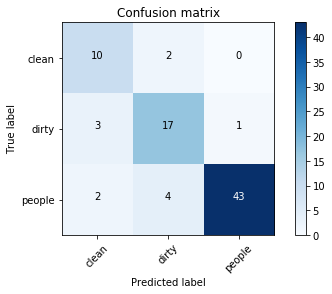

In [361]:
plot_confusion_matrix(cm, data.classes)

In [329]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
  

In [330]:
def show_wrong(data, class_num, preds):
    class_match = (data.val_y == class_num)
    incorrect_match = (data.val_y != preds)
    mask = class_match*incorrect_match
    idxs = np.where(mask)[0]
    imgs = [data.val_ds.denorm(data.val_ds[idx][0])[0] for idx in idxs]
    guess = preds[idxs]
    plot_val_with_title2(imgs, guess)
    
    return

def plot_val_with_title2(imgs,  guess, num_imgs = 4):
    return plots(imgs[:4], rows=2, titles=guess)

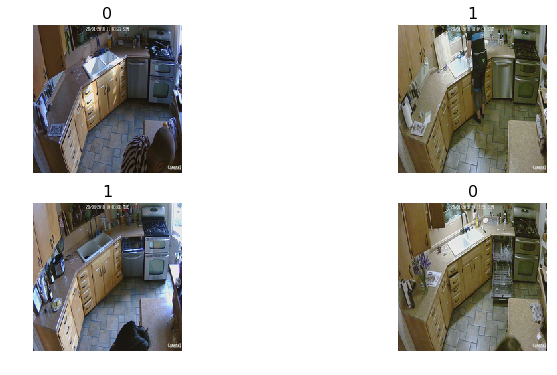

In [350]:
# Shows a sample of incorrect predictions for class #2
show_wrong(data, class_num = 2, preds)